In [1]:
import numpy as np
import requests
import os
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import mdtraj as md
import nglview as nv
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Working with the Anisotropic Network Model

## Downloading any PDB file

Let's first of all store the PDB id we want to download and the path where the file needs to be located:

In [2]:
pdb_id = '1HIV'
download_path = "./"

And now let's define an auxiliary function to download pdb files to be stored locally in our machine.

In [3]:
def fetch_pdb(pdb_id, download_path="./"):
        url = 'http://files.rcsb.org/download/{}.pdb'.format(pdb_id)
        try:
            res = requests.get(url, allow_redirects=True)
        except:
            print("Could not fetch pdb from {}".format(url))
            return 
        
        file_path = os.path.join(download_path, pdb_id + ".pdb")
        with open(file_path, "wb") as f:
            f.write(res.content)
        print(f"The {pdb_id} file was downloaded succesfully!")

Time to try it!

In [4]:
fetch_pdb(pdb_id, download_path=download_path)

The 1HIV file was downloaded succesfully!


## Parsing the positions of the CA atoms

We are going take an approach not very short and efficient to obtain the coordinates of the CA atoms. But let's do it this way just once:

In [5]:
file_path = os.path.join(download_path, pdb_id + ".pdb")

CA_coordinates = []

with open(file_path) as fff:
    for line in fff.readlines():
        if line.startswith('ATOM  ') and line.split()[2]=='CA' :
          
            x, y, z = line.split()[6:9]
            CA_coordinates.append([float(x), float(y), float(z)])

Ok, `CA_coordinates` is a list of lists... let's convert it to a numpy array:

In [6]:
CA_coordinates = np.array(CA_coordinates)

In [7]:
#Alpha carbon number
len(CA_coordinates)

196

## Defining the equivalent Hessian matrix of the elastic 3D model

In [16]:
def anm_matrix(CA, threshold):
    num_CAs = CA.shape[0]
    matrix = np.zeros((3*num_CAs, 3*num_CAs), dtype=float)
    for ii in range(num_CAs):
        for jj in range(ii):
            rij=CA[ii]-CA[jj]
            distance=np.sqrt(np.dot(rij,rij))
            if distance<threshold:
                #Defining H_ij diagonal elements
                x=0
                for kk, ll in zip(range(ii*3,ii*3+3), range(jj*3,jj*3+3)):
                    matrix[kk,ll]=-(CA[jj][x]-CA[ii][x])**2/distance
                    x+=1
                    
                    
                #H_ij off diagonal elements
                matrix[ii*3,jj*3+1]=-(CA[jj][0]-CA[ii][0])*(CA[jj][1]-CA[ii][1])/distance
                matrix[ii*3+1,jj*3]=-matrix[ii*3,jj*3+1] #Según Atilgan (2001) está definido como negativo pero en otros lugares lo veo como positivo
                
                matrix[ii*3,jj*3+2]=-(CA[jj][0]-CA[ii][0])*(CA[jj][2]-CA[ii][2])/distance
                matrix[ii*3+2,jj*3]=-matrix[ii*3,jj*3+2]
                
                matrix[ii*3+1,jj*3+2]=-(CA[jj][1]-CA[ii][1])*(CA[jj][2]-CA[ii][2])/distance
                matrix[ii*3+2,jj*3+1]=-matrix[ii*3+1,jj*3+2]
                
               #Faltan los "super elementos" de la diagonal 
                

                
    return matrix

In [17]:
matrix = anm_matrix(CA_coordinates, 9.0)
matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.16558358e-03,  6.65916950e-02, -8.49991554e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.65916950e-02, -2.04769462e+00,  2.61372403e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.49991554e-02, -2.61372403e+00, -3.33621685e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Diagonalizing from its eigenvalues

In [105]:
evals, evects = eigh(matrix)

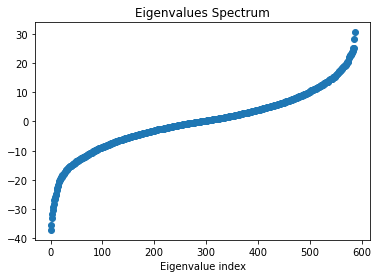

In [106]:
num_modes = evals.shape[0]

plt.scatter(range(num_modes), evals)
plt.title('Eigenvalues Spectrum')
plt.xlabel('Eigenvalue index')
plt.show()

Ahora los modos normales contienen una componente $x$, $y$ y $z$ para cada CA. ¿Cómo podemos hacer una representación similar a la que hacíamos en el GNM para ver la amplitud participación de cada CA en el modo? ¿Qué tal si representamos algo como $\sqrt{x_{i}^{2} + y_{i}^{2} + z_{i}^{2}}$ para cada CA de índice $i$ en un mismo modo?

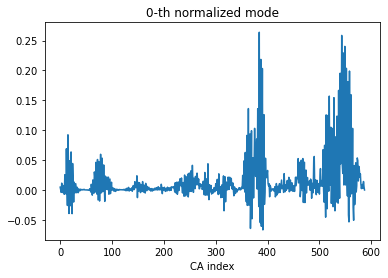

In [108]:
# Esto viene de GNM y debe ser adaptado para ANM
mode_index = 0
plt.plot(range(num_modes), evects[:,mode_index])
plt.title(f'{mode_index}-th normalized mode')
plt.xlabel('CA index')
plt.show()